In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.api import ARDL
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch
from sklearn.metrics import mean_squared_error
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
def format_quarters(x, pos):
    date = mdates.num2date(x)  # Convert matplotlib date to datetime
    quarter = (date.month - 1) // 3 + 1  # Calculate the quarter
    if quarter == 1:  # Show year only for Q1
        return f"{date.year}-Q{quarter}"
    else:  # Show only the quarter for Q2, Q3, Q4
        return f"Q{quarter}"

In [3]:
# Define date range
start_date = datetime.datetime(1988, 1, 1)
end_date = datetime.datetime(2024, 12, 31)

Merged DataFrame:
            Annual Inflation Rate  Quarterly GDP Change  \
DATE                                                      
1988-06-30               4.562353              1.305474   
1988-09-30               4.847178              0.584260   
1988-12-31               4.346052              1.323657   
1989-03-31               4.518577              1.011264   
1989-06-30               6.414052              0.760203   

            Interest Rate Quarterly  Unemployment Rate Quarterly  
DATE                                                              
1988-06-30                 8.910000                     5.466667  
1988-09-30                 9.100000                     5.466667  
1988-12-31                 8.956667                     5.333333  
1989-03-31                 9.206667                     5.200000  
1989-06-30                 8.773333                     5.233333  


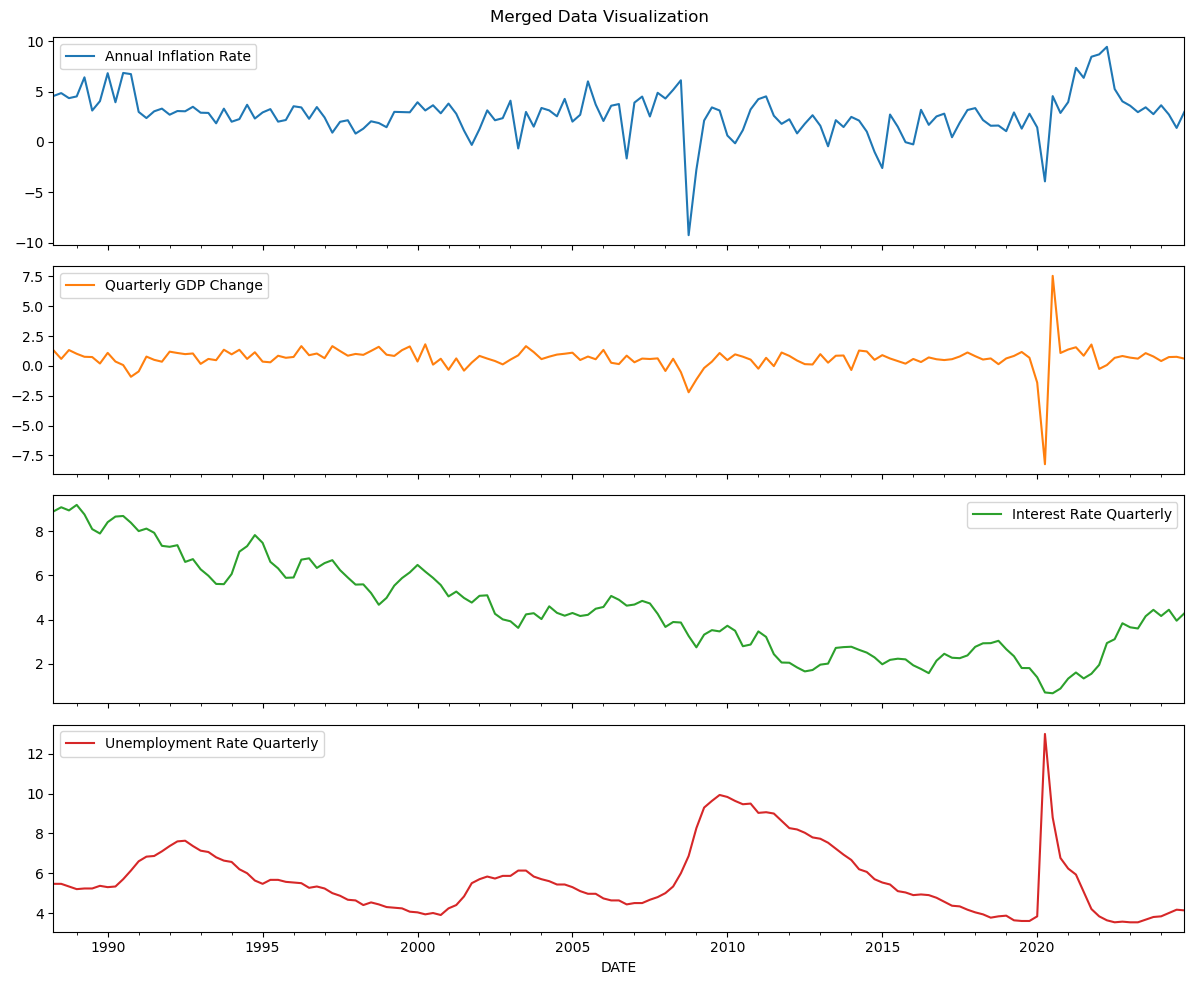

In [4]:
# Download CPI data
df_cpi = web.DataReader('CPIAUCSL', 'fred', start_date, end_date)
df_cpi.dropna(inplace=True)

# Create a column for quarterly CPI using 3-month average (only at quarter-end months)
df_cpi['Quarterly CPI'] = df_cpi['CPIAUCSL'].rolling(window=3).mean()

# Keep only the months that are quarter-ends: March, June, September, December
df_cpi_quarterly = df_cpi[df_cpi.index.month.isin([3, 6, 9, 12])].copy()

# Compute annualized inflation rate
df_cpi_quarterly['Annual Inflation Rate'] = 400 * np.log(
    df_cpi_quarterly['Quarterly CPI'] / df_cpi_quarterly['Quarterly CPI'].shift(1)
)

df_unemp = web.DataReader('UNRATE', 'fred', start_date, end_date)
df_unemp_quarterly = df_unemp.resample('QE').mean()
df_unemp_quarterly.rename(columns={'UNRATE': 'Unemployment Rate Quarterly'}, inplace=True)
df_unemp_quarterly

df_interest = web.DataReader('GS10', 'fred', start_date, end_date)
df_interest_quarterly = df_interest.resample('QE').mean()
df_interest_quarterly.rename(columns={'GS10': 'Interest Rate Quarterly'}, inplace=True)
df_interest_quarterly

df_gdp = web.DataReader('GDPC1', 'fred', start_date, end_date)
# Compute quarterly GDP change (log difference * 100)
df_gdp['Quarterly GDP Change'] = np.log(df_gdp['GDPC1']).diff() * 100
df_gdp.index = pd.to_datetime(df_gdp.index)
# Convert to quarterly period and then get the quarter-end timestamp
df_gdp.index = df_gdp.index.to_period('Q').to_timestamp('Q')
df_gdp.dropna(subset=['Quarterly GDP Change'], inplace=True)
df_gdp

# Ensure all indices are in quarterly frequency and aligned
df_cpi_quarterly.index = df_cpi_quarterly.index.to_period('Q').to_timestamp('Q')
df_gdp.index = df_gdp.index.to_period('Q').to_timestamp('Q')
df_interest_quarterly.index = df_interest_quarterly.index.to_period('Q').to_timestamp('Q')
df_unemp_quarterly.index = df_unemp_quarterly.index.to_period('Q').to_timestamp('Q')

# Merge all DataFrames into a single DataFrame
df_merged = pd.concat([
    df_cpi_quarterly['Annual Inflation Rate'],
    df_gdp['Quarterly GDP Change'],
    df_interest_quarterly['Interest Rate Quarterly'],
    df_unemp_quarterly['Unemployment Rate Quarterly']
], axis=1, join='inner')

# Rename columns for clarity
df_merged.columns = ['Annual Inflation Rate', 'Quarterly GDP Change', 'Interest Rate Quarterly', 'Unemployment Rate Quarterly']

# Drop rows with missing values
df_merged.dropna(inplace=True)

# Display the merged DataFrame
print("Merged DataFrame:")
print(df_merged.head())


df_merged.plot(subplots=True, figsize=(12, 10), title="Merged Data Visualization")
plt.tight_layout()
plt.show()



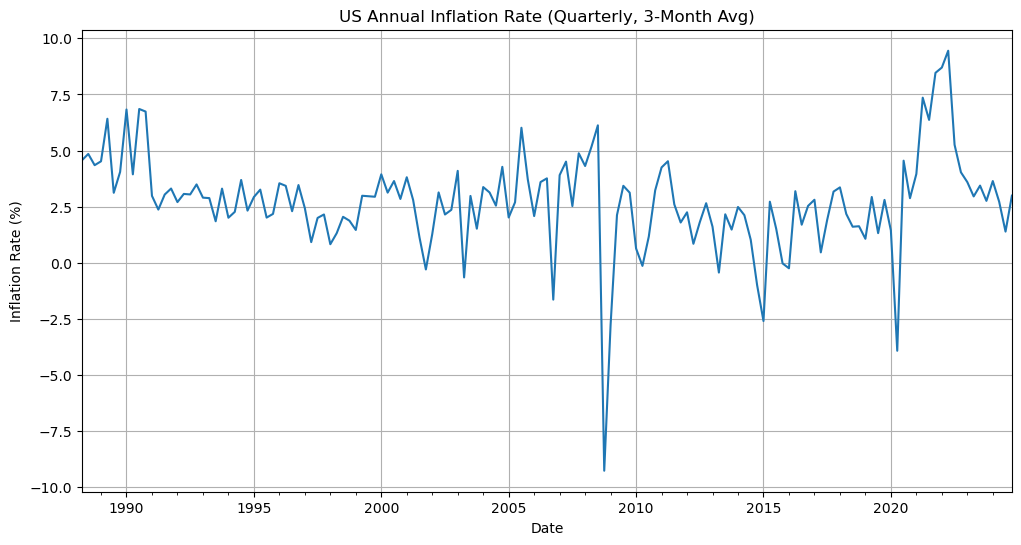

In [5]:
df_inflation = df_cpi_quarterly.dropna()

# Plot
df_inflation['Annual Inflation Rate'].plot(title='US Annual Inflation Rate (Quarterly, 3-Month Avg)', figsize=(12, 6))
plt.xlabel('Date')
plt.ylabel('Inflation Rate (%)')
plt.grid(True)
plt.show()

In [6]:
# Extract the Annual Inflation Rate series
inflation_rate_series = df_inflation['Annual Inflation Rate']

# Perform the ADF test
adf_result = adfuller(inflation_rate_series)

# Display the results
adf_output = pd.Series(adf_result[0:4], index=['Test Statistic', 'p-value', '# of Lags Used', 'Number of Observations Used'])
for key, value in adf_result[4].items():
    adf_output[f'Critical Value ({key})'] = value

print("Augmented Dickey-Fuller Test Results:")
display(adf_output)

Augmented Dickey-Fuller Test Results:


Test Statistic                -7.662569e+00
p-value                        1.673539e-11
# of Lags Used                 0.000000e+00
Number of Observations Used    1.460000e+02
Critical Value (1%)           -3.475953e+00
Critical Value (5%)           -2.881548e+00
Critical Value (10%)          -2.577439e+00
dtype: float64

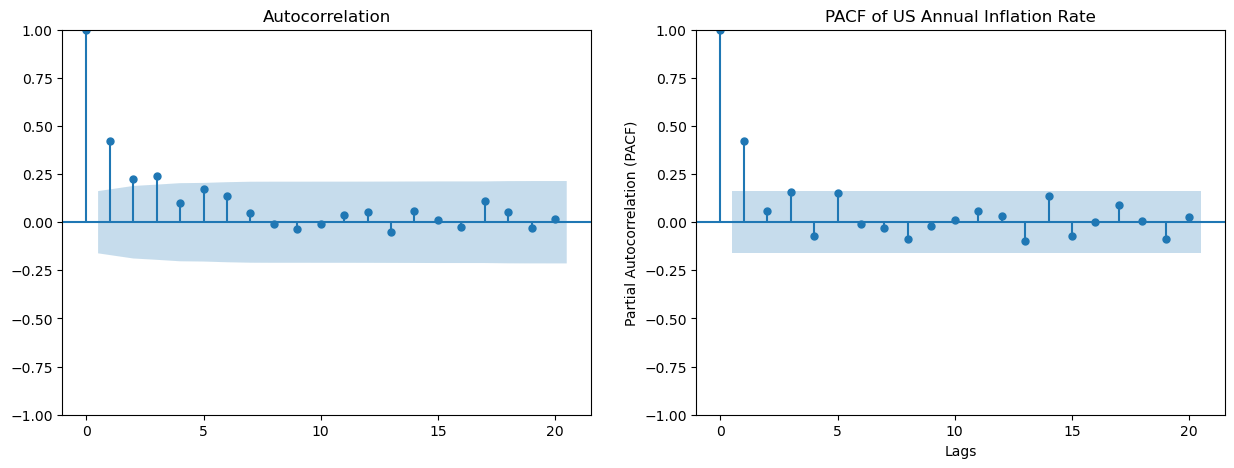

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot ACF for the annual inflation rate
plot_acf(inflation_rate_series, lags=20, ax=axes[0])
# Plot the PACF for the annual inflation rate
plot_pacf(inflation_rate_series, lags=20, ax=axes[1])
plt.title("PACF of US Annual Inflation Rate")
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation (PACF)')
plt.show()

In [8]:
# Fit an AR(1) model
model_ar1 = AutoReg(df_inflation['Annual Inflation Rate'], lags=1).fit()
print("AR(1) Model Summary:")
display(model_ar1.summary())


p = 6

# Fit an AR(p) model
model_arp = AutoReg(df_inflation['Annual Inflation Rate'], lags=p).fit()
print(f"\nAR({p}) Model Summary:")
display(model_arp.summary())

AR(1) Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                              AutoReg Model Results                              
=================================================================================
Dep. Variable:     Annual Inflation Rate   No. Observations:                  147
Model:                        AutoReg(1)   Log Likelihood                -307.163
Method:                  Conditional MLE   S.D. of innovations              1.984
Date:                   Thu, 17 Apr 2025   AIC                            620.326
Time:                           10:24:05   BIC                            629.277
Sample:                       09-30-1988   HQIC                           623.963
                            - 12-31-2024                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        1.5609      0.262      5.966      0.000       1.048       2.074
Annual Inflation Rate.L1     0.4231      0.075      5.658      0.000       0.277       0.570
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.3636           +0.0000j            2.3636            0.0000
-----------------------------------------------------------------------------
"""


AR(6) Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                              AutoReg Model Results                              
=================================================================================
Dep. Variable:     Annual Inflation Rate   No. Observations:                  147
Model:                        AutoReg(6)   Log Likelihood                -293.340
Method:                  Conditional MLE   S.D. of innovations              1.938
Date:                   Thu, 17 Apr 2025   AIC                            602.680
Time:                           10:24:05   BIC                            626.270
Sample:                       12-31-1989   HQIC                           612.266
                            - 12-31-2024                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        1.1330      0.358      3.166      0.002       0.432       1.834
Annual Inflation Rate.L1     0.4073      0.084      4.842      0.000       0.242       0.572
Annual Inflation Rate.L2    -0.0396      0.089     -0.444      0.657      -0.214       0.135
Annual Inflation Rate.L3     0.1802      0.089      2.034      0.042       0.007       0.354
Annual Inflation Rate.L4    -0.1342      0.089     -1.515      0.130      -0.308       0.039
Annual Inflation Rate.L5     0.1624      0.089      1.819      0.069      -0.013       0.337
Annual Inflation Rate.L6    -0.0085      0.083     -0.102      0.919      -0.172       0.155
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.9587           -1.0141j            1.3955           -0.3705
AR.2           -0.9587           +1.0141j            1.3955            0.3705
AR.3            1.2827           -0.0000j            1.2827           -0.0000
AR.4            0.7172           -1.4349j            1.6042           -0.1762
AR.5            0.7172           +1.4349j            1.6042            0.1762
AR.6           18.2680           -0.0000j           18.2680           -0.0000
-----------------------------------------------------------------------------
"""

In [9]:
def calculate_AR_model(df_inflation, lags):

    # Extract the 'Annual Inflation Rate' column
    inflation_rates = df_inflation['Annual Inflation Rate']

    # Fit the AR model
    model = AutoReg(inflation_rates, lags=lags)
    model_fit = model.fit()

    # Print the model summary
    display(model_fit.summary())

    # Get the AR coefficients (excluding the intercept term)
    ar_coef = model_fit.params[1:]

    # Print AR coefficients
    print("\nAR Coefficients:")
    display(ar_coef)

    # Get the residuals
    residuals = model_fit.resid

    # Plot the ACF of residuals
    plt.figure(figsize=(12, 6))
    plot_acf(residuals, lags=12, alpha=0.05)
    plt.title("Autocorrelation Function (ACF) of Residuals")
    plt.show()

    # Perform the Ljung-Box test on residuals
    lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
    print("Ljung-Box Test Results for Residuals:")
    display(lb_test)

    # Return results
    return model_fit, ar_coef, lb_test, residuals


In [10]:
results = []
for i in range(1, 13):  

    model = AutoReg(inflation_rate_series, lags=i)
    model_fit = model.fit()
    aic = model_fit.aic
    bic = model_fit.bic
    results.append([i, aic, bic])
    print(f"AR({i}): AIC={aic:.2f}, BIC={bic:.2f}")

# Find the best models based on AIC and BIC
results_df = pd.DataFrame(results, columns=['Lag', 'AIC', 'BIC'])
best_aic_model = results_df.loc[results_df['AIC'].idxmin()]  # Find row with minimum AIC
best_bic_model = results_df.loc[results_df['BIC'].idxmin()]  # Find row with minimum BIC


print(f"\nBest Model (AIC): Lag {int(best_aic_model['Lag'])}, AIC={best_aic_model['AIC']:.2f}, BIC={best_aic_model['BIC']:.2f}")
print(f"Best Model (BIC): Lag {int(best_bic_model['Lag'])}, AIC={best_bic_model['AIC']:.2f}, BIC={best_bic_model['BIC']:.2f}")

AR(1): AIC=620.33, BIC=629.28
AR(2): AIC=618.15, BIC=630.05
AR(3): AIC=613.18, BIC=628.03
AR(4): AIC=611.09, BIC=628.87
AR(5): AIC=604.28, BIC=624.97
AR(6): AIC=602.68, BIC=626.27
AR(7): AIC=601.19, BIC=627.66
AR(8): AIC=596.67, BIC=626.01
AR(9): AIC=595.46, BIC=627.66
AR(10): AIC=591.30, BIC=626.34
AR(11): AIC=588.37, BIC=626.23
AR(12): AIC=586.82, BIC=627.50

Best Model (AIC): Lag 12, AIC=586.82, BIC=627.50
Best Model (BIC): Lag 5, AIC=604.28, BIC=624.97


In [11]:
test_data = df_inflation.loc[df_inflation.index >= '2022-06-01']
train_data = df_inflation.loc[df_inflation.index < '2022-06-01']

n = 60

predictions = pd.DataFrame(index= train_data.index, columns=range(1, 13))
rmse = {}


for p in range(1, 13):
    
    rmse[p] = 0
    
    for index in range(n, len(train_data)-1):  # Ensure the range covers all valid indices
    
        # Train the model on data up to the current index
        model = AutoReg(train_data['Annual Inflation Rate'][:index+1], lags=p).fit()
        # Predict the next time step (index)
        predictions[p][index+1] = model.predict(start=index+1, end=index+1).values[0]
        
    rmse[p] = np.sqrt(mean_squared_error(train_data['Annual Inflation Rate'][n+1:], predictions[p][n+1:]))

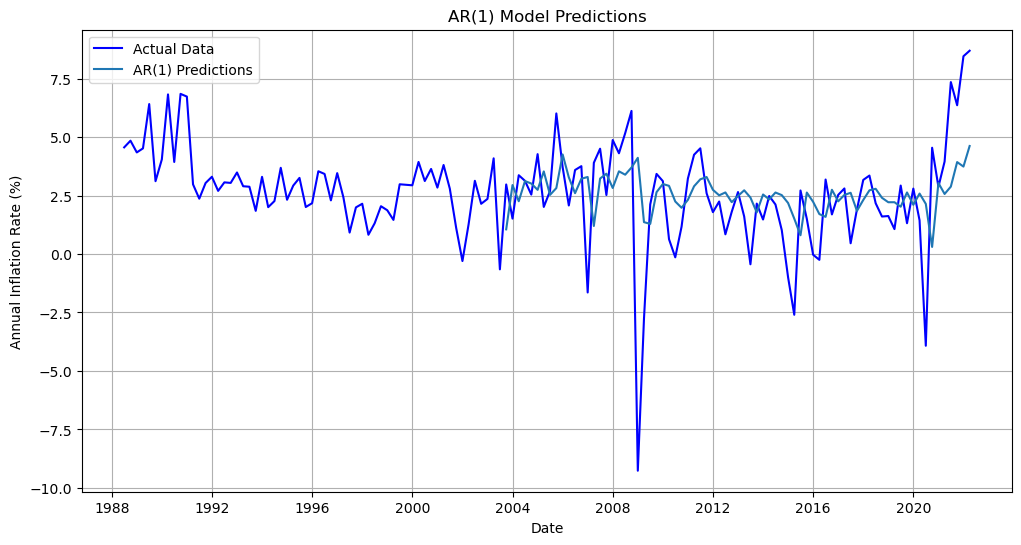

In [12]:
# Plot the predictions for AR(1) model
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Annual Inflation Rate'], label='Actual Data', color='blue')
plt.plot(predictions.index, predictions[1], label=f'AR(1) Predictions')
plt.title('AR(1) Model Predictions')
plt.xlabel('Date')
plt.ylabel('Annual Inflation Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

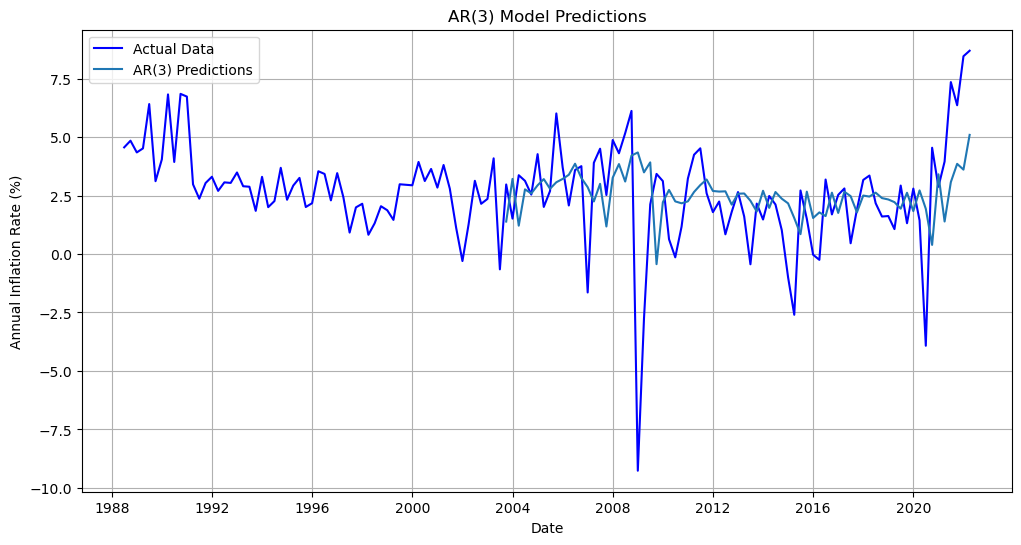

In [13]:
# Plot the predictions for AR(3) model
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Annual Inflation Rate'], label='Actual Data', color='blue')
plt.plot(predictions.index, predictions[3], label=f'AR(3) Predictions')
plt.title('AR(3) Model Predictions')
plt.xlabel('Date')
plt.ylabel('Annual Inflation Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

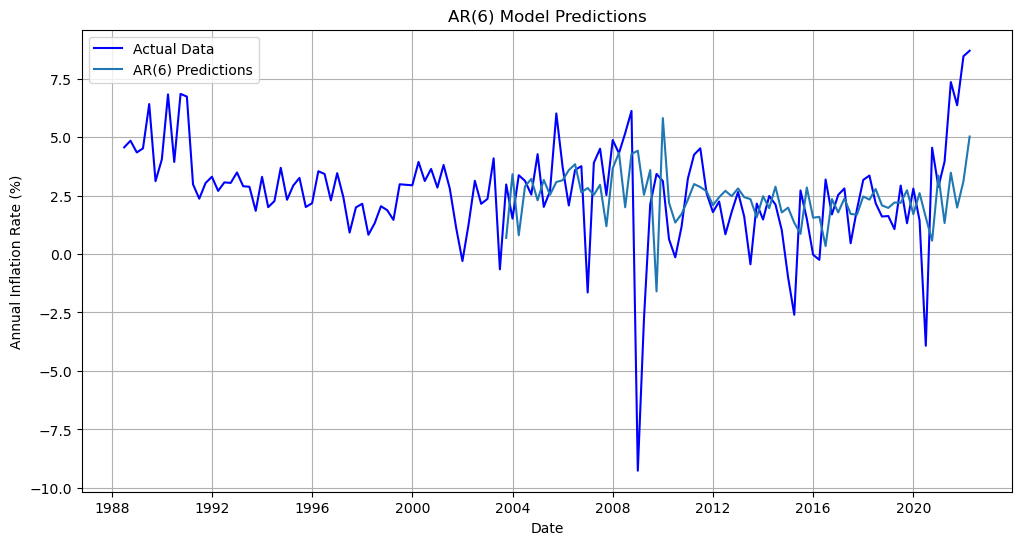

In [14]:
# plot the predictions for AR(6) model
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Annual Inflation Rate'], label='Actual Data', color='blue')
plt.plot(predictions.index, predictions[6], label=f'AR(6) Predictions')
plt.title('AR(6) Model Predictions')
plt.xlabel('Date')
plt.ylabel('Annual Inflation Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

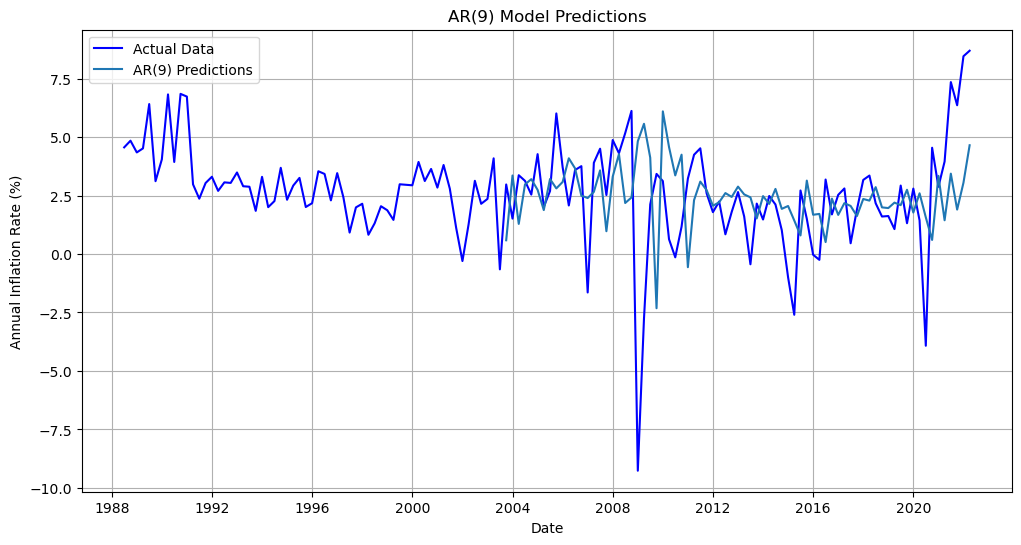

In [15]:
# plot the predictions for AR(9) model
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Annual Inflation Rate'], label='Actual Data', color='blue')
plt.plot(predictions.index, predictions[9], label=f'AR(9) Predictions')
plt.title('AR(9) Model Predictions')
plt.xlabel('Date')
plt.ylabel('Annual Inflation Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

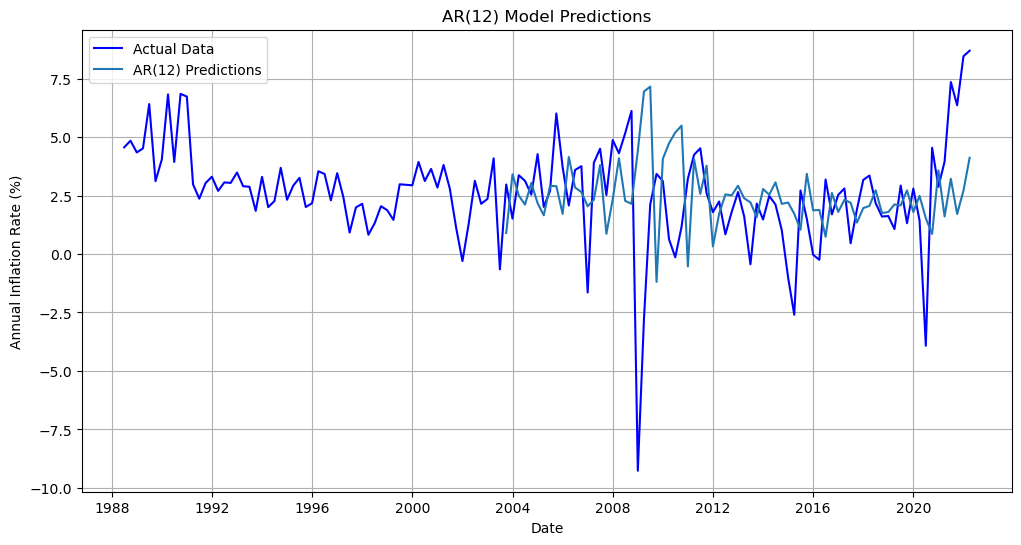

In [16]:
# Plot the predictions for AR(12) model
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Annual Inflation Rate'], label='Actual Data', color='blue')
plt.plot(predictions.index, predictions[12], label=f'AR(12) Predictions')
plt.title('AR(12) Model Predictions')
plt.xlabel('Date')
plt.ylabel('Annual Inflation Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# Print the RMSE values for each model

for p in range(1, 13):
    print(f"AR({p}) RMSE: {rmse[p]:.4f}")

AR(1) RMSE: 2.5394
AR(2) RMSE: 2.5683
AR(3) RMSE: 2.6204
AR(4) RMSE: 2.6462
AR(5) RMSE: 2.6228
AR(6) RMSE: 2.6690
AR(7) RMSE: 2.7048
AR(8) RMSE: 2.8781
AR(9) RMSE: 2.9622
AR(10) RMSE: 3.0002
AR(11) RMSE: 3.0369
AR(12) RMSE: 3.0992


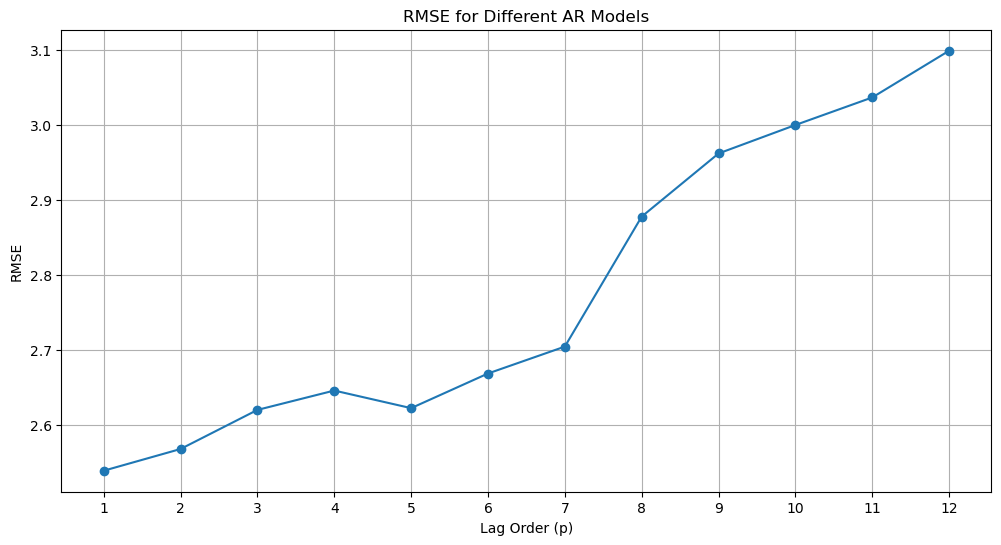

In [18]:
# Plot the RMSE values for each model
plt.figure(figsize=(12, 6))
plt.plot(range(1, 13), list(rmse.values()), marker='o')  # Extract values from the rmse dictionary
plt.title('RMSE for Different AR Models')
plt.xlabel('Lag Order (p)')
plt.ylabel('RMSE')
plt.xticks(range(1, 13))
plt.grid(True)
plt.show()

In [19]:
# Fit ARDL model with exogs
test_data1 = df_inflation.loc[df_inflation.index >= '2022-06-01']
train_data1 = df_inflation.loc[df_inflation.index < '2022-06-01']
test_data = test_data1['Annual Inflation Rate']
train_data = train_data1['Annual Inflation Rate']

exog = df_merged[['Quarterly GDP Change', 'Interest Rate Quarterly', 'Unemployment Rate Quarterly']]
train_exog = exog.loc[exog.index < '2022-06-01']
test_exog = exog.loc[exog.index >= '2022-06-01']

# Initialize variables to store the best model
best_aic = np.inf
best_bic = np.inf
best_lag = None
best_order = None

for p in range(1, 13):
    for q in range(1, 13):
        model_ardl = ARDL(train_data, lags=p, exog=train_exog, order = q ).fit()
        
        if model_ardl.aic < best_aic:
            best_aic = model_ardl.aic
            best_order = (p, q)
            best_model = model_ardl
        
        if model_ardl.bic < best_bic:
            best_bic = model_ardl.bic
            best_lag = (p, q)
            best_model_bic = model_ardl

# Print the best ARDL model based on AIC and BIC
print(f"Best ARDL Model (AIC): Lag Order {best_order}, AIC={best_aic:.2f}")
display(best_model.summary())
print(f"Best ARDL Model (BIC): Lag Order {best_lag}, BIC={best_bic:.2f}")
display(best_model_bic.summary())
        
    

Best ARDL Model (AIC): Lag Order (12, 1), AIC=527.49


<class 'statsmodels.iolib.summary.Summary'>
"""
                                ARDL Model Results                               
=================================================================================
Dep. Variable:     Annual Inflation Rate   No. Observations:                  136
Model:                 ARDL(12, 1, 1, 1)   Log Likelihood                -243.743
Method:                  Conditional MLE   S.D. of innovations              1.728
Date:                   Thu, 17 Apr 2025   AIC                            527.486
Time:                           10:24:20   BIC                            583.891
Sample:                       06-30-1991   HQIC                           550.399
                            - 03-31-2022                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              1.0749      0.939      1.144      0.255      -0.788       2.938
Annual Inflation Rate.L1           0.3453      0.098      3.541      0.001       0.152       0.539
Annual Inflation Rate.L2          -0.0008      0.098     -0.008      0.993      -0.196       0.194
Annual Inflation Rate.L3           0.1506      0.097      1.559      0.122      -0.041       0.342
Annual Inflation Rate.L4          -0.0373      0.099     -0.375      0.709      -0.234       0.160
Annual Inflation Rate.L5           0.0910      0.098      0.927      0.356      -0.104       0.286
Annual Inflation Rate.L6           0.0513      0.101      0.510      0.611      -0.148       0.251
Annual Inflation Rate.L7          -0.0448      0.102     -0.440      0.661      -0.246       0.157
Annual Inflation Rate.L8           0.0244      0.104      0.235      0.815      -0.181       0.230
Annual Inflation Rate.L9          -0.0626      0.104     -0.605      0.547      -0.268       0.143
Annual Inflation Rate.L10          0.0357      0.102      0.348      0.728      -0.167       0.239
Annual Inflation Rate.L11          0.0055      0.102      0.055      0.957      -0.196       0.207
Annual Inflation Rate.L12          0.0957      0.100      0.958      0.340      -0.102       0.294
Quarterly GDP Change.L0            0.8282      0.380      2.178      0.032       0.074       1.582
Quarterly GDP Change.L1            0.1373      0.191      0.719      0.474      -0.241       0.516
Interest Rate Quarterly.L0         0.9973      0.524      1.904      0.060      -0.041       2.036
Interest Rate Quarterly.L1        -1.1101      0.513     -2.163      0.033      -2.128      -0.092
Unemployment Rate Quarterly.L0     0.2002      0.440      0.455      0.650      -0.673       1.074
Unemployment Rate Quarterly.L1    -0.2533      0.436     -0.581      0.563      -1.118       0.611
==================================================================================================
"""

Best ARDL Model (BIC): Lag Order (5, 1), BIC=583.14


<class 'statsmodels.iolib.summary.Summary'>
"""
                                ARDL Model Results                               
=================================================================================
Dep. Variable:     Annual Inflation Rate   No. Observations:                  136
Model:                  ARDL(5, 1, 1, 1)   Log Likelihood                -259.883
Method:                  Conditional MLE   S.D. of innovations              1.759
Date:                   Thu, 17 Apr 2025   AIC                            545.766
Time:                           10:24:20   BIC                            583.143
Sample:                       09-30-1989   HQIC                           560.954
                            - 03-31-2022                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              0.8035      0.887      0.905      0.367      -0.954       2.561
Annual Inflation Rate.L1           0.3733      0.091      4.110      0.000       0.193       0.553
Annual Inflation Rate.L2          -0.0030      0.092     -0.033      0.974      -0.185       0.179
Annual Inflation Rate.L3           0.1823      0.089      2.043      0.043       0.006       0.359
Annual Inflation Rate.L4          -0.0772      0.092     -0.837      0.404      -0.260       0.105
Annual Inflation Rate.L5           0.1380      0.090      1.535      0.128      -0.040       0.316
Quarterly GDP Change.L0            0.5026      0.336      1.498      0.137      -0.162       1.167
Quarterly GDP Change.L1            0.0377      0.175      0.215      0.830      -0.309       0.384
Interest Rate Quarterly.L0         1.2660      0.481      2.634      0.010       0.314       2.218
Interest Rate Quarterly.L1        -1.2500      0.472     -2.650      0.009      -2.184      -0.316
Unemployment Rate Quarterly.L0    -0.1061      0.400     -0.265      0.791      -0.898       0.686
Unemployment Rate Quarterly.L1     0.0837      0.393      0.213      0.832      -0.694       0.862
==================================================================================================
"""

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.ardl import ARDL
from sklearn.metrics import mean_squared_error

test_data1 = df_inflation.loc[df_inflation.index >= '2022-06-01']
train_data1 = df_inflation.loc[df_inflation.index < '2022-06-01']
test_data = test_data1['Annual Inflation Rate']
train_data = train_data1['Annual Inflation Rate']
exog = df_merged[['Quarterly GDP Change', 'Interest Rate Quarterly', 'Unemployment Rate Quarterly']]
train_exog = exog.loc[exog.index < '2022-06-01']
test_exog = exog.loc[exog.index >= '2022-06-01']


model_ardl = ARDL(train_data, lags=12, exog=train_exog, order=1, causal =True )
result = model_ardl.fit()


# Extract coefficients by position
coefficients = result.params
print(coefficients)


#  Extract Coefficients by Position
n_ar = 12  # Number of AR lags
n_exog = 3  # Number of exogenous variables

intercept = coefficients[0]  # Constant term
ar_coefs = coefficients[1:n_ar+1]  

# Exogenous coefficients 
gdp_lag1 = coefficients[n_ar+1]      
interest_lag1 = coefficients[n_ar+2] 
unemp_lag1 = coefficients[n_ar+3]  

#Manual Forecasting Function
def manual_ardl_forecast(train_endog, test_endog, train_exog, test_exog, 
                        intercept, ar_coefs, gdp_lag1, interest_lag1, unemp_lag1):
    
    combined_endog = pd.concat([train_endog, test_endog])
    combined_exog = pd.concat([train_exog, test_exog])
    predictions = []
    
    for i in range(len(train_endog), len(combined_endog)):
        # AR Component (5 lags)
        ar_lags = combined_endog.iloc[i-12:i].values[::-1]  # Most recent first
        ar_component = np.dot(ar_coefs, ar_lags)
        

        lagged_exog = combined_exog.iloc[i-1]
        exog_component = (
                gdp_lag1 * lagged_exog['Quarterly GDP Change'] +
                interest_lag1 * lagged_exog['Interest Rate Quarterly'] +
                unemp_lag1 * lagged_exog['Unemployment Rate Quarterly']
            )

            
        # Combine all components
        y_hat = intercept + ar_component + exog_component
        predictions.append(y_hat)
    
    return pd.Series(predictions, index=test_endog.index)

# 4. Generate Forecasts
pred_manual = manual_ardl_forecast(
    train_data, test_data, train_exog, test_exog,
    intercept, ar_coefs, gdp_lag1, interest_lag1, unemp_lag1
)



const                             0.986070
Annual Inflation Rate.L1          0.355594
Annual Inflation Rate.L2         -0.055134
Annual Inflation Rate.L3          0.148924
Annual Inflation Rate.L4         -0.129092
Annual Inflation Rate.L5          0.137898
Annual Inflation Rate.L6         -0.012348
Annual Inflation Rate.L7         -0.062766
Annual Inflation Rate.L8         -0.009818
Annual Inflation Rate.L9         -0.080369
Annual Inflation Rate.L10        -0.014133
Annual Inflation Rate.L11         0.035713
Annual Inflation Rate.L12         0.036905
Quarterly GDP Change.L1           0.055753
Interest Rate Quarterly.L1        0.018040
Unemployment Rate Quarterly.L1    0.081558
dtype: float64


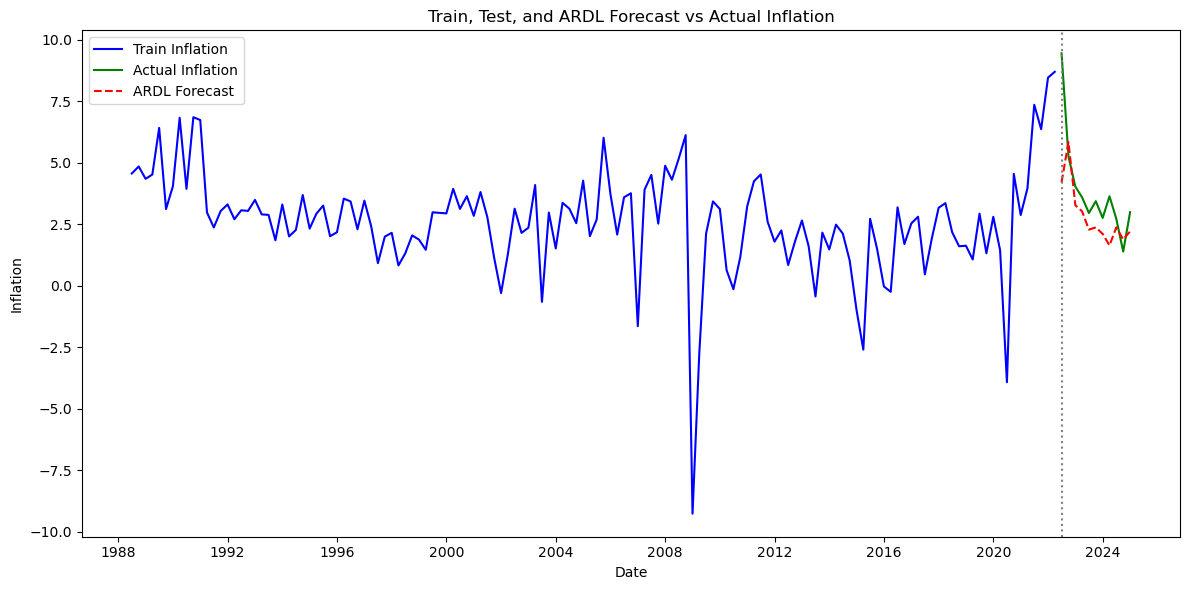

RMSE for ARDL: 1.8010017936081562


In [21]:

# Plotting train, test, and forecast data
plt.figure(figsize=(12, 6))

# Plot the train data
plt.plot(train_data, label="Train Inflation", color='blue')

# Plot the test data (actual)
plt.plot(test_data, label="Actual Inflation", color='green')

# Plot the ARDL forecast
plt.plot(pred_manual, label="ARDL Forecast", linestyle='--', color='red')

# Add a vertical line to show the train/test split
plt.axvline(x=test_data.index[0], color='gray', linestyle=':')

# Add titles and labels
plt.title("Train, Test, and ARDL Forecast vs Actual Inflation")
plt.xlabel("Date")
plt.ylabel("Inflation")

# Show the legend
plt.legend()

# Adjust layout for better display
plt.tight_layout()

# Show the plot
plt.show()

# Calculate and print RMSE
rmse = np.sqrt(mean_squared_error(test_data, pred_manual))
print(f"RMSE for ARDL: {rmse}")


In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error

def ar_forecast(p):

 
    test_data1 = df_inflation.loc[df_inflation.index >= '2022-06-01']
    train_data1 = df_inflation.loc[df_inflation.index < '2022-06-01']
    
    test_data = test_data1['Annual Inflation Rate']
    train_data = train_data1['Annual Inflation Rate']
    
    # Fit AR(p) on train_data only
    model_ar = AutoReg(train_data, lags=p).fit()
    coef = model_ar.params  # Intercept + coefficients

    # Combine full data for manual forecasting
    combined_data = pd.concat([train_data, test_data]).copy()

    # Manual prediction loop using actual values
    pred_ar = []

    for i in range(len(train_data), len(combined_data)):
        lags_values = combined_data.iloc[i-p:i].values[::-1]  # lagged actual values, reversed
        y_hat = coef[0] + np.dot(coef[1:], lags_values)  # Intercept + lag coefficients
        pred_ar.append(y_hat)

    # Store as a Series
    pred_ar = pd.Series(pred_ar, index=test_data.index)

    # Plot forecast vs actual for AR(p) model
    plt.figure(figsize=(12, 6))

    # Plot the train data
    plt.plot(train_data, label="Train Inflation", color='blue')

    # Plot the test data (actual)
    plt.plot(test_data, label="Actual Inflation", color='green')

    # Plot the AR(p) forecast
    plt.plot(pred_ar, label=f"AR({p}) Forecast", linestyle='--', color='red')

    # Add a vertical line to show the train/test split
    plt.axvline(x=test_data.index[0], color='gray', linestyle=':')

    # Add titles and labels
    plt.title(f"Train, Test, and AR({p}) Forecast vs Actual Inflation")
    plt.xlabel("Date")
    plt.ylabel("Inflation")

    # Show the legend
    plt.legend()

    # Adjust layout for better display
    plt.tight_layout()

    # Show the plot
    plt.show()

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test_data, pred_ar))
    print(f"RMSE for AR({p}): {rmse}")
    
    return pred_ar, coef, rmse




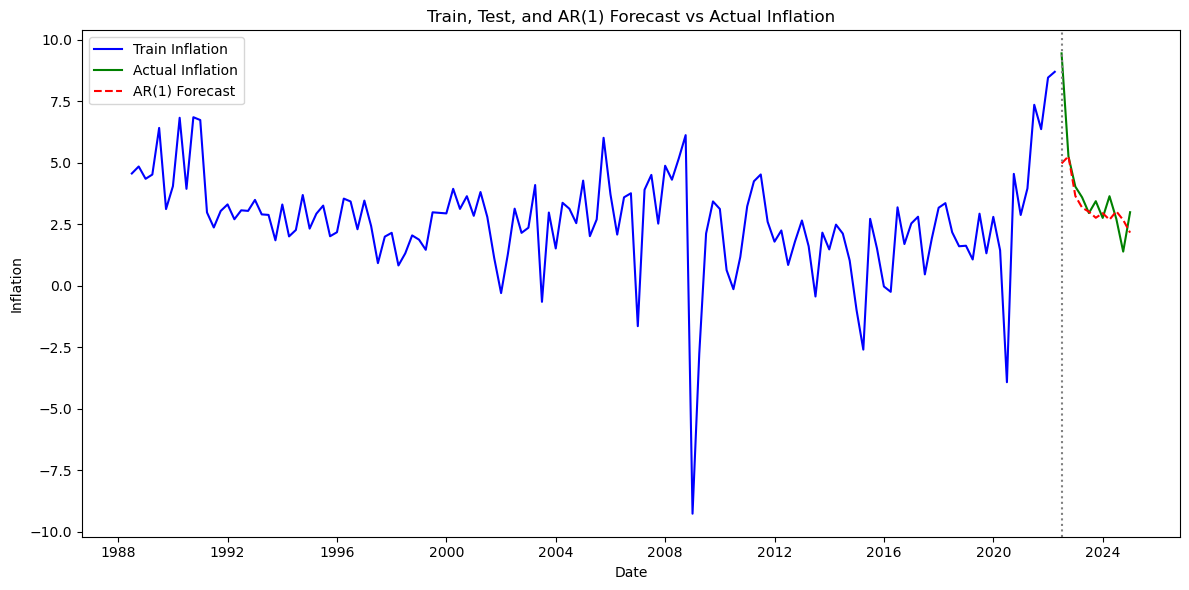

RMSE for AR(1): 1.4822572865262322


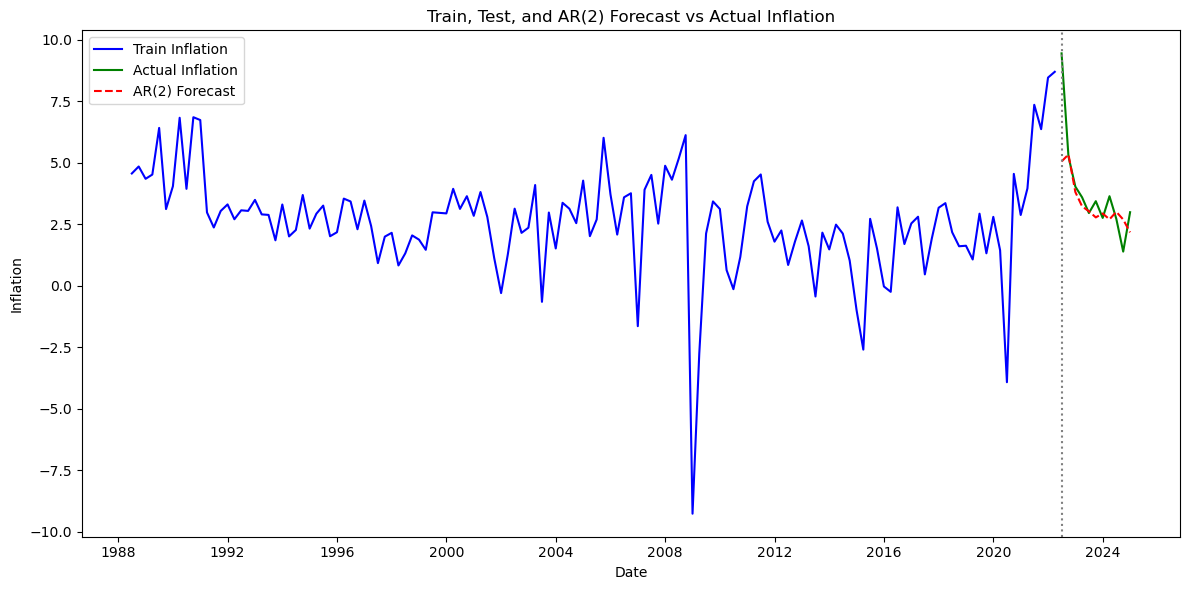

RMSE for AR(2): 1.4559596640655887


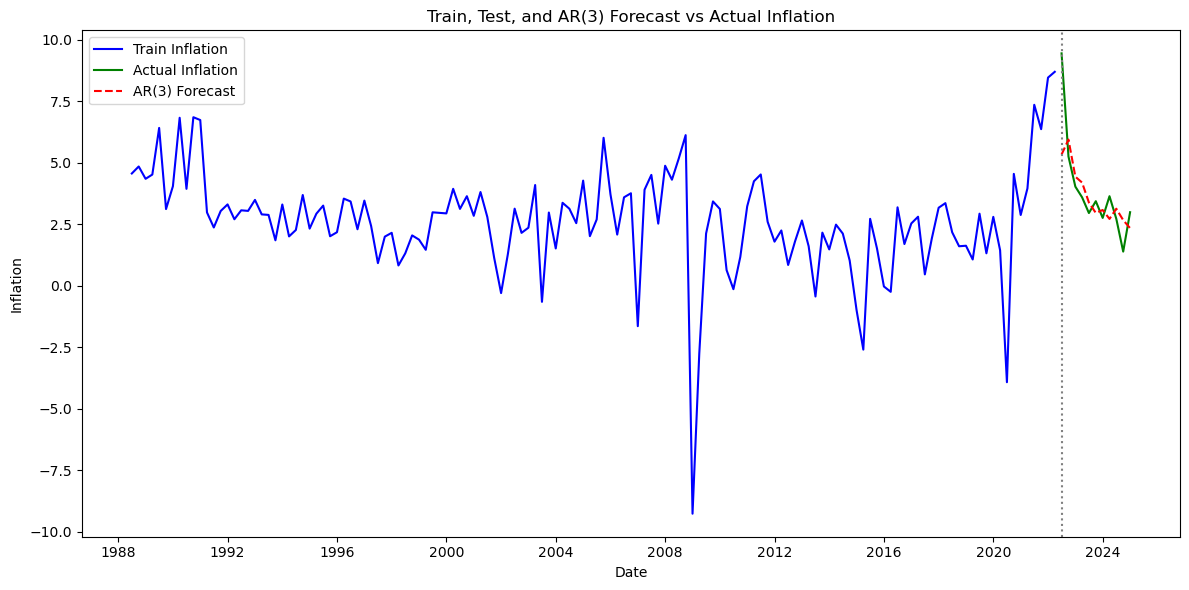

RMSE for AR(3): 1.398133053828498


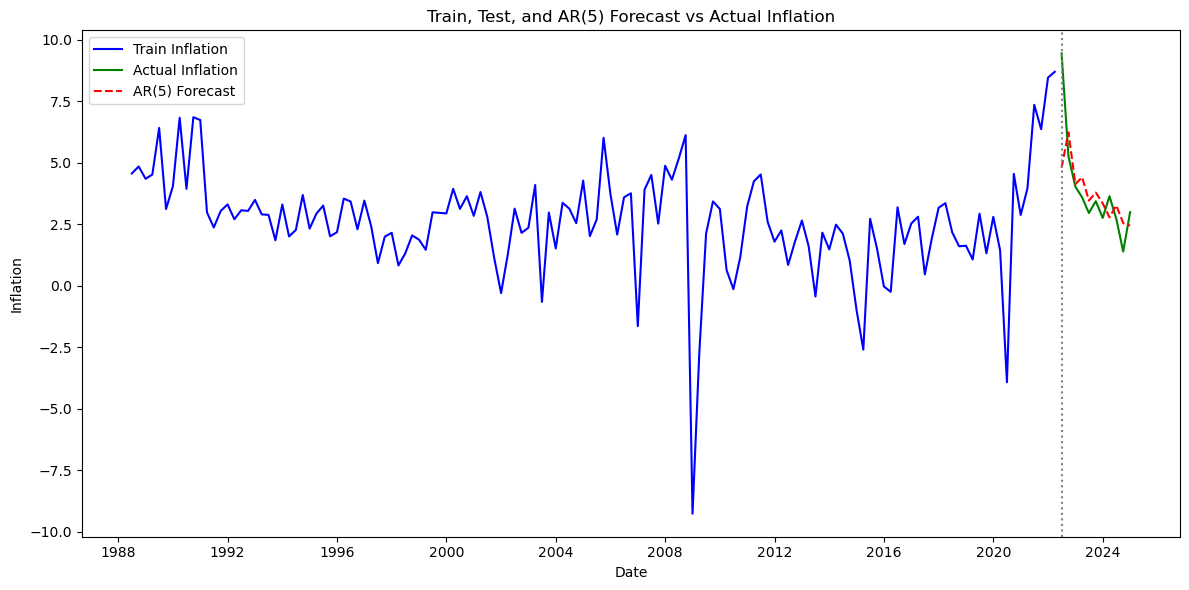

RMSE for AR(5): 1.5566202539032712


In [23]:
pred1, coef1, rmse1= ar_forecast(1)
pred2, coef2, rmse2= ar_forecast(2)
pred3, coef3, rmse3= ar_forecast(3)
pred5, coef5, rmse5= ar_forecast(5)

In [24]:
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg

# Fit AR(1) model to the data
model_ar3 = AutoReg(df_inflation['Annual Inflation Rate'], lags=3).fit()

# Predict the next 4 points
predictions1year = model_ar3.forecast(steps=4)

# Print the predicted values
print(f"Predictions for the next 4 points: {predictions1year}")



Predictions for the next 4 points: 2025-03-31    2.804958
2025-06-30    2.515232
2025-09-30    2.657280
2025-12-31    2.684657
Freq: QE-DEC, dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                              AutoReg Model Results                              
=================================================================================
Dep. Variable:     Annual Inflation Rate   No. Observations:                  147
Model:                        AutoReg(3)   Log Likelihood                -301.590
Method:                  Conditional MLE   S.D. of innovations              1.965
Date:                   Thu, 17 Apr 2025   AIC                            613.180
Time:                           10:24:25   BIC                            628.029
Sample:                       03-31-1989   HQIC                           619.214
                            - 12-31-2024                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        1.2383      0.314      3.940      0.000       0.622       1.854
Annual Inflation Rate.L1     0.3838      0.082      4.663      0.000       0.222       0.545
Annual Inflation Rate.L2    -0.0059      0.088     -0.067      0.946      -0.179       0.167
Annual Inflation Rate.L3     0.1574      0.082      1.917      0.055      -0.004       0.318
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4323           -0.0000j            1.4323           -0.0000
AR.2           -0.6973           -1.9874j            2.1061           -0.3037
AR.3           -0.6973           +1.9874j            2.1061            0.3037
-----------------------------------------------------------------------------
"""


AR Coefficients:


Annual Inflation Rate.L1    0.383793
Annual Inflation Rate.L2   -0.005948
Annual Inflation Rate.L3    0.157395
dtype: float64

<Figure size 1200x600 with 0 Axes>

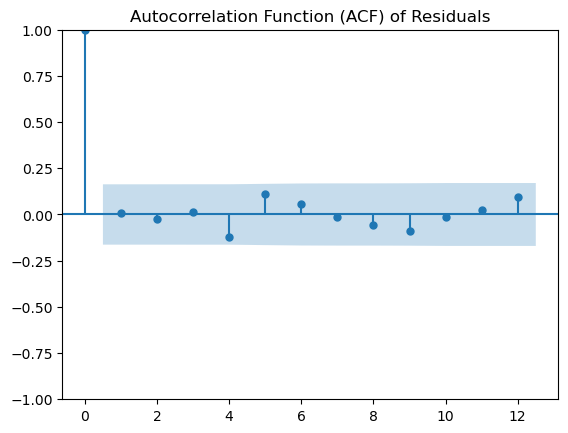

Ljung-Box Test Results for Residuals:


,lb_stat,lb_pvalue
10,6.490565,0.772503


In [25]:
model_fit3, ar_coef3, lb_test3, residuals3 = calculate_AR_model(df_inflation, lags=3)

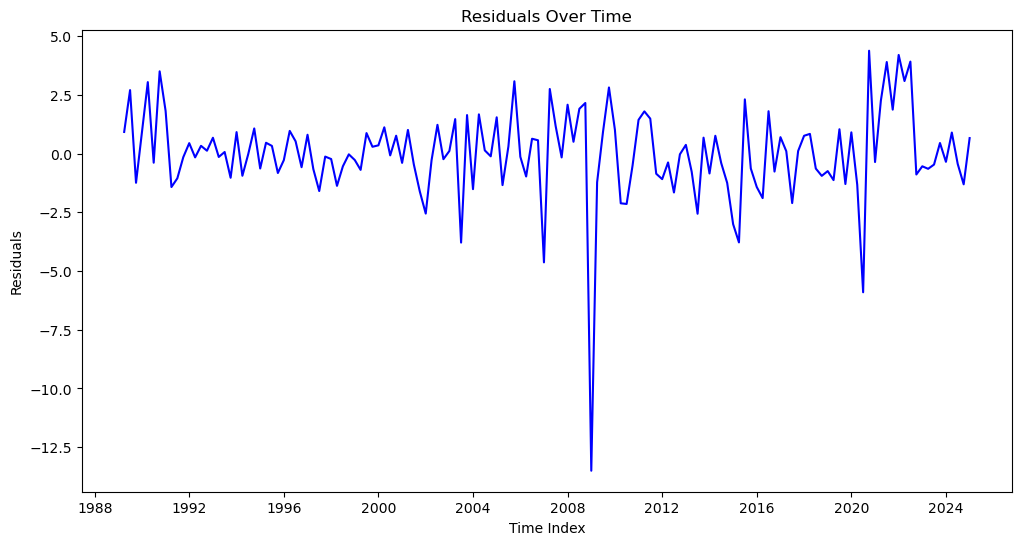

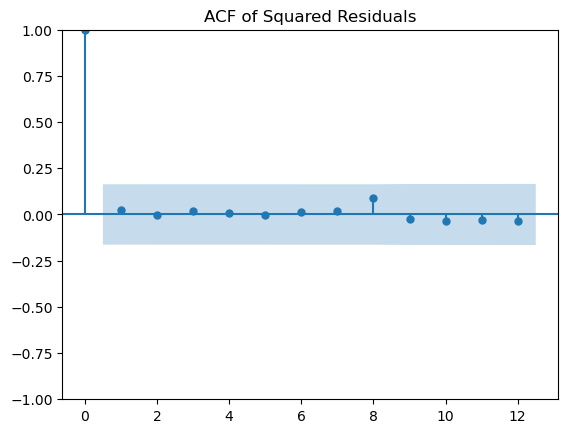

ARCH Test Results:
LM Statistic      1.531346
p-value           0.998834
F-statistic       0.142189
F-test p-value    0.999057
dtype: float64


In [26]:
# Plot the residuals to visually inspect for volatility clustering
plt.figure(figsize=(12, 6))
plt.plot(residuals3, color='blue')
plt.title('Residuals Over Time')
plt.xlabel('Time Index')
plt.ylabel('Residuals')
plt.show()

# Plot the ACF of squared residuals (common way to detect ARCH effects)
plot_acf(residuals3 ** 2, lags=12, alpha = 0.05)
plt.title('ACF of Squared Residuals')
plt.show()

# Perform the ARCH-LM Test
arch_test = het_arch(residuals3)
arch_test_results = pd.Series(arch_test, index=['LM Statistic', 'p-value', 'F-statistic', 'F-test p-value'])

print("ARCH Test Results:")
print(arch_test_results)


Best Hyperparameters: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.6}
Validation RMSE (static): 2.4786
Test RMSE (static): 3.0601
Validation Rolling RMSE: 2.3664
Test Rolling RMSE: 2.4529

5-Step-Ahead Forecast with Static Predictions:
2025-03-31    2.590752
2025-06-30    2.550809
2025-09-30    2.610339
2025-12-31    2.602473
2026-03-31    2.671369
Freq: QE-DEC, dtype: float32


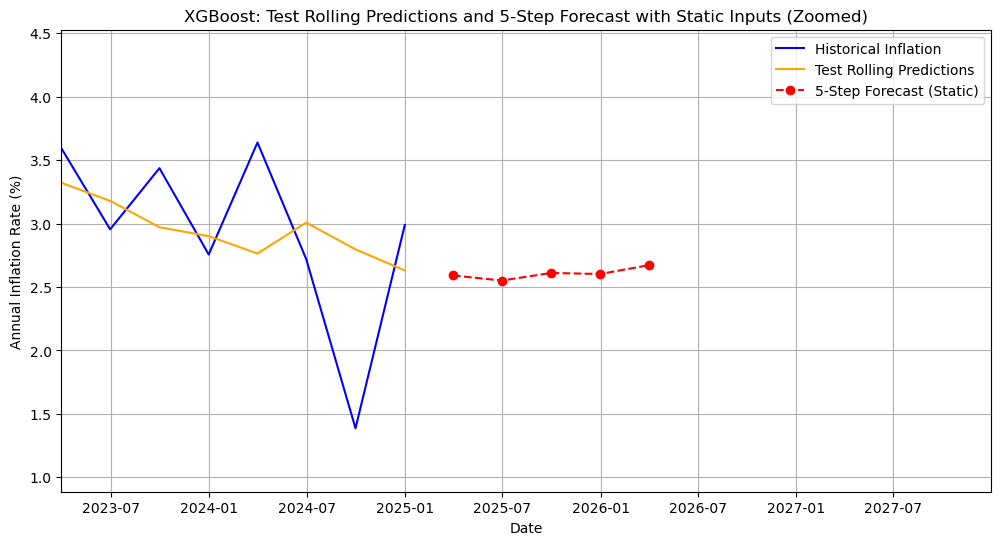

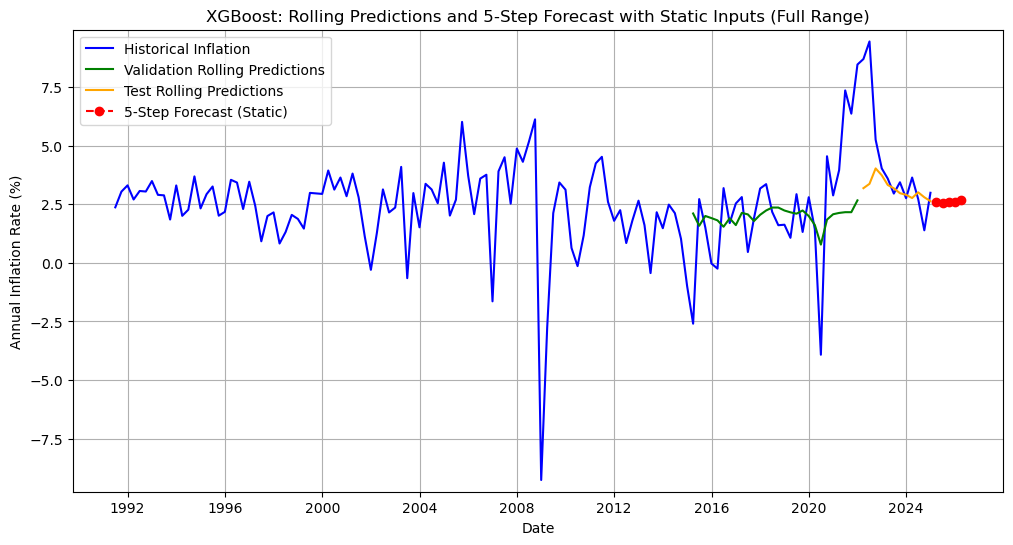

In [27]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error

# Lagged features
lags = 12
df_lagged = df_merged.copy()
for lag in range(1, lags + 1):
    df_lagged[f'Annual Inflation Rate_lag{lag}'] = df_lagged['Annual Inflation Rate'].shift(lag)

# Feature Engineering
df_lagged['GDP_Interest_Interaction'] = df_lagged['Quarterly GDP Change'] * df_lagged['Interest Rate Quarterly']
df_lagged['GDP_Unemployment_Interaction'] = df_lagged['Quarterly GDP Change'] * df_lagged['Unemployment Rate Quarterly']
df_lagged['Interest_Unemployment_Interaction'] = df_lagged['Interest Rate Quarterly'] * df_lagged['Unemployment Rate Quarterly']
df_lagged['Inflation_Volatility'] = df_lagged['Annual Inflation Rate'].rolling(window=4).std()
df_lagged['Recession_2008'] = (df_lagged.index.year.isin([2008, 2009])).astype(int)
df_lagged['COVID_2020'] = (df_lagged.index.year >= 2020).astype(int)
df_lagged['Trend'] = np.arange(len(df_lagged))

# Drop rows with NaN values
df_lagged = df_lagged.dropna()

# Features
exog_cols = ['Quarterly GDP Change', 'Interest Rate Quarterly', 'Unemployment Rate Quarterly']
additional_features = [
    'GDP_Interest_Interaction',
    'GDP_Unemployment_Interaction',
    'Interest_Unemployment_Interaction',
    'Inflation_Volatility',
    'Recession_2008',
    'COVID_2020',
    'Trend'
]
feature_cols = [f'Annual Inflation Rate_lag{i}' for i in range(1, lags + 1)] + exog_cols + additional_features

# Train-test-val split
train_end = '2015-03-31'
val_end = '2022-03-31'
train_data_xgb = df_lagged[df_lagged.index < train_end]
val_data_xgb = df_lagged[(df_lagged.index >= train_end) & (df_lagged.index < val_end)]
test_data_xgb = df_lagged[df_lagged.index >= val_end]

X_train = train_data_xgb[feature_cols]
y_train = train_data_xgb['Annual Inflation Rate']
X_val = val_data_xgb[feature_cols]
y_val = val_data_xgb['Annual Inflation Rate']
X_test = test_data_xgb[feature_cols]
y_test = test_data_xgb['Annual Inflation Rate']

# XGBoost model with hyperparameter tuning
model_xgb = xgb.XGBRegressor(objective='reg:squarederror')
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 7, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}
tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(estimator=model_xgb, param_grid=param_grid, cv=tscv,
                           scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model
best_model_xgb = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)

# Validation set evaluation
y_pred_val = best_model_xgb.predict(X_val)
mse_val = mean_squared_error(y_val, y_pred_val)
rmse_val = np.sqrt(mse_val)
print(f"Validation RMSE (static): {rmse_val:.4f}")

# Test set evaluation
y_pred_test = best_model_xgb.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
print(f"Test RMSE (static): {rmse_test:.4f}")

# Rolling predictions for validation and test periods
rolling_predictions_xgb = pd.Series(index=df_lagged.index, dtype=float)
rolling_window = 50

for i in range(rolling_window, len(df_lagged)):
    train_data = df_lagged.iloc[:i]
    test_data = df_lagged.iloc[i:i+1]
    X_train_roll = train_data[feature_cols]
    y_train_roll = train_data['Annual Inflation Rate']
    X_test_roll = test_data[feature_cols]
    model = xgb.XGBRegressor(objective='reg:squarederror', **grid_search.best_params_)
    model.fit(X_train_roll, y_train_roll)
    pred = model.predict(X_test_roll)
    rolling_predictions_xgb.iloc[i] = pred[0]

# Split rolling predictions into validation and test
val_rolling_pred = rolling_predictions_xgb.loc[val_data_xgb.index]
test_rolling_pred = rolling_predictions_xgb.loc[test_data_xgb.index]

# Compute RMSE for rolling predictions
rmse_rolling_val = np.sqrt(mean_squared_error(y_val, val_rolling_pred))
rmse_rolling_test = np.sqrt(mean_squared_error(y_test, test_rolling_pred))
print(f"Validation Rolling RMSE: {rmse_rolling_val:.4f}")
print(f"Test Rolling RMSE: {rmse_rolling_test:.4f}")

# Recursive forecasting with static predictions
def xgb_recursive_forecast_with_static(model, last_data, feature_cols, steps=5, static_preds=None, static_index=None):
    if isinstance(last_data, pd.DataFrame):
        last_data = last_data.iloc[-1]
    current_features = last_data[feature_cols].copy()
    last_date = last_data.name
    future_dates = pd.date_range(start=last_date, periods=steps+1, freq='Q')[1:]
    predictions = []

    # Convert static predictions to a Series if provided
    static_preds_series = None
    if static_preds is not None and static_index is not None:
        static_preds_series = pd.Series(static_preds, index=static_index)

    for step in range(steps):
        # Predict using current features
        pred = model.predict(current_features.values.reshape(1, -1))[0]
        predictions.append(pred)

        # Update lagged features
        for lag in range(lags, 1, -1):
            current_features[f'Annual Inflation Rate_lag{lag}'] = \
                current_features[f'Annual Inflation Rate_lag{lag-1}']

        # Use static predictions for lag1 if available and within static index
        if static_preds_series is not None and step < len(static_preds_series):
            current_features['Annual Inflation Rate_lag1'] = static_preds_series.iloc[step]
        else:
            current_features['Annual Inflation Rate_lag1'] = pred

        # Update trend feature
        if 'Trend' in current_features:
            current_features['Trend'] += 1

    return pd.Series(predictions, index=future_dates)

# apply forecasting 
last_data_point = df_lagged.iloc[-1]
static_predictions = y_pred_test  # Static predictions from test set
static_index = test_data_xgb.index  # Index of test set

forecast_5_steps_static = xgb_recursive_forecast_with_static(
    best_model_xgb,
    last_data_point,
    feature_cols,
    steps=5,
    static_preds=static_predictions,
    static_index=static_index
)
print("\n5-Step-Ahead Forecast with Static Predictions:")
print(forecast_5_steps_static)

# Plot 1: Zoomed-in plot with static-based forecast
plt.figure(figsize=(12, 6))
plt.plot(df_lagged.index, df_lagged['Annual Inflation Rate'], label='Historical Inflation', color='blue')
plt.plot(test_rolling_pred.index, test_rolling_pred, label='Test Rolling Predictions', color='orange', linestyle='-')
plt.plot(forecast_5_steps_static.index, forecast_5_steps_static, label='5-Step Forecast (Static)', color='red', linestyle='--', marker='o')
plt.xlim(pd.to_datetime('2023-03-31'), pd.to_datetime('2027-12-31'))
visible_data = pd.concat([
    df_lagged['Annual Inflation Rate'].loc[df_lagged.index >= '2023-03-31'],
    test_rolling_pred,
    forecast_5_steps_static
])
y_min = visible_data.min() - 0.5
y_max = visible_data.max() + 0.5
plt.ylim(y_min, y_max)
plt.title('XGBoost: Test Rolling Predictions and 5-Step Forecast with Static Inputs (Zoomed)')
plt.xlabel('Date')
plt.ylabel('Annual Inflation Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: Full range plot with static-based forecast
plt.figure(figsize=(12, 6))
plt.plot(df_lagged.index, df_lagged['Annual Inflation Rate'], label='Historical Inflation', color='blue')
plt.plot(val_rolling_pred.index, val_rolling_pred, label='Validation Rolling Predictions', color='green', linestyle='-')
plt.plot(test_rolling_pred.index, test_rolling_pred, label='Test Rolling Predictions', color='orange', linestyle='-')
plt.plot(forecast_5_steps_static.index, forecast_5_steps_static, label='5-Step Forecast (Static)', color='red', linestyle='--', marker='o')
visible_data_full = pd.concat([
    df_lagged['Annual Inflation Rate'],
    val_rolling_pred,
    test_rolling_pred,
    forecast_5_steps_static
])
y_min_full = visible_data_full.min() - 0.5
y_max_full = visible_data_full.max() + 0.5
plt.ylim(y_min_full, y_max_full)
plt.title('XGBoost: Rolling Predictions and 5-Step Forecast with Static Inputs (Full Range)')
plt.xlabel('Date')
plt.ylabel('Annual Inflation Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

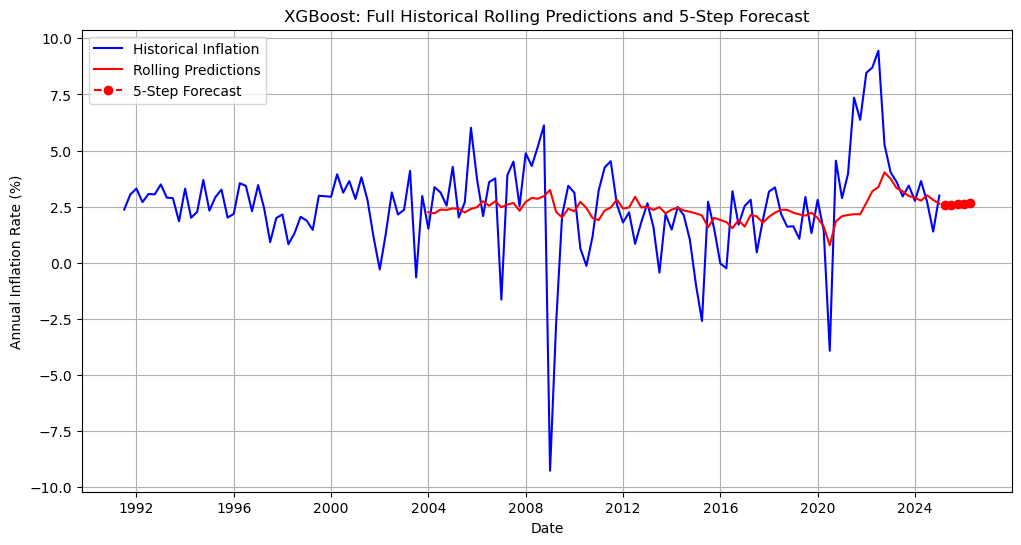

In [28]:
# Plot full historical rolling predictions vs actual historical inflation
plt.figure(figsize=(12, 6))
plt.plot(df_lagged.index, df_lagged['Annual Inflation Rate'], label='Historical Inflation', color='blue', linestyle='-')
plt.plot(rolling_predictions_xgb.index, rolling_predictions_xgb, label='Rolling Predictions', color='red', linestyle='-')
plt.plot(forecast_5_steps_static.index, forecast_5_steps_static, label='5-Step Forecast', color='red', linestyle='--', marker='o')

# Add titles and labels
plt.title('XGBoost: Full Historical Rolling Predictions and 5-Step Forecast')
plt.xlabel('Date')
plt.ylabel('Annual Inflation Rate (%)')
plt.legend()
plt.grid(True)
plt.show()